# REFL Assignment #2
# Gridworld
Vinodh Chincholi



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Helper Functions for Environment

In [2]:
def compute_action_probability(state, action, params, temp):
    numerator = np.exp(temp * params[state[0], state[1], action])
    denominator = np.sum(np.exp(temp * params[state[0], state[1]]))
    return numerator / denominator

def move_to_new_state(state, action, grid_dim, obstacles):
    x, y = state
    if action == 0:  # move up
        x = max(0, x - 1)
    elif action == 1:  # move down
        x = min(grid_dim - 1, x + 1)
    elif action == 2:  # move left
        y = max(0, y - 1)
    elif action == 3:  # move right
        y = min(grid_dim - 1, y + 1)
    if (x, y) in obstacles:
        return state
    return (x, y)

def simulate_episode(grid_dim, target, danger, obstacles, params, temp, discount_factor):
    current_state = (0, 0)
    total_reward = 0
    discount = 1
    state_history, action_history, reward_history = [], [], []

    while current_state != target:
        state_history.append(current_state)
        action_probs = [compute_action_probability(current_state, a, params, temp) for a in range(4)]
        chosen_action = np.random.choice(4, p=np.array(action_probs))
        
        if chosen_action == 0:
            action = np.random.choice(4, p=[0.8, 0.1, 0.05, 0.05])
        elif chosen_action == 1:
            action = np.random.choice(4, p=[0.1, 0.8, 0.05, 0.05])
        elif chosen_action == 2:
            action = np.random.choice(4, p=[0.05, 0.05, 0.8, 0.1])
        else:
            action = np.random.choice(4, p=[0.05, 0.05, 0.1, 0.8])
        
        action_history.append(action)
        next_state = move_to_new_state(current_state, action, grid_dim, obstacles)
        reward = determine_reward(next_state, target, danger) * discount
        reward_history.append(reward)
        total_reward += reward
        current_state = next_state
        discount *= discount_factor

    return total_reward, state_history, action_history, reward_history

def determine_reward(state, target, danger):
    if state == target:
        return 10
    elif state == danger:
        return -10
    else:
        return 0

## Helper Functions that REINFORCE will use

In [3]:
def apply_discount(rewards, discount_factor):
    discounted = np.zeros_like(rewards)
    cumulative_sum = 0
    for t in reversed(range(len(rewards))):
        cumulative_sum = cumulative_sum * discount_factor + rewards[t]
        discounted[t] = cumulative_sum
    return discounted

def update_params(params, states, actions, discounted_rewards, temp, discount_factor, learning_rate):
    gradient = np.zeros_like(params)
    delta = 0.001
    for t in range(len(states)):
        state = states[t]
        action = actions[t]
        G_t = discounted_rewards[t]
        prob = compute_action_probability(state, action, params, temp)
        params_delta = np.copy(params)
        params_delta[state[0], state[1], action] += delta
        prob_delta = compute_action_probability(state, action, params_delta, temp)
        grad_log_prob = (np.log(prob_delta) - np.log(prob)) / delta
        gradient[state[0], state[1], action] += (discount_factor ** t) * G_t * grad_log_prob
    params += learning_rate * gradient
    return params

def update_params_with_baseline(params, baseline, states, actions, discounted_rewards, rewards, temp, discount_factor, learning_rate, lambda_reg, value_weight_rate):
    grad_params = np.zeros_like(params)
    grad_baseline = np.zeros_like(baseline)
    delta = 0.001
    for t in range(len(states) - 1):
        state = states[t]
        action = actions[t]
        G_t = discounted_rewards[t]
        prob = compute_action_probability(state, action, params, temp)
        params_delta = np.copy(params)
        params_delta[state[0], state[1], action] += delta
        prob_delta = compute_action_probability(state, action, params_delta, temp)
        grad_log_prob = (np.log(prob_delta) - np.log(prob)) / delta
        v_baseline_state = np.sum(baseline[state[0], state[1]])
        td_error = rewards[t] + discount_factor * np.sum(baseline[states[t+1][0], states[t+1][1]]) - v_baseline_state
        grad_v_baseline = np.zeros_like(baseline)
        grad_v_baseline[state[0], state[1], action] = 1
        grad_baseline = discount_factor * lambda_reg * grad_baseline + grad_v_baseline
        params += learning_rate * (discount_factor ** t) * (G_t - v_baseline_state) * grad_log_prob
        baseline += value_weight_rate * td_error * grad_baseline
    return params, baseline

def analyze_rewards(all_rewards, discount_factor):
    max_len = max(len(rewards) for rewards in all_rewards)
    padded_rewards = np.array([rewards + [10 * (discount_factor ** k)] * (max_len - len(rewards)) for k, rewards in enumerate(all_rewards)])
    avg_reward = np.mean(padded_rewards, axis=0)
    reward_error = np.std(padded_rewards, axis=0) / np.sqrt(len(all_rewards))
    return avg_reward, reward_error


## REINFORCE & Baseline REINFORCE

In [4]:
def reinforce(grid_dim, target, danger, obstacles, temp, tolerance, max_runs, num_trials, discount_factor, learning_rate):
    all_rewards = []
    for _ in range(num_trials):
        params = np.random.rand(grid_dim, grid_dim, 4)
        run_rewards = []
        for run in range(max_runs):
            total_reward, states, actions, rewards = simulate_episode(grid_dim, target, danger, obstacles, params, temp, discount_factor)
            discounted_rewards = apply_discount(rewards, discount_factor)
            params = update_params(params, states, actions, discounted_rewards, temp, discount_factor, learning_rate)
            run_rewards.append(total_reward)
            if run > 0 and abs(run_rewards[-1] - run_rewards[-2]) < tolerance:
                break
        all_rewards.append(run_rewards)
    avg_reward, reward_error = analyze_rewards(all_rewards, discount_factor)
    return avg_reward, reward_error

def reinforce_with_baseline(grid_dim, target, danger, obstacles, temp, tolerance, max_runs, num_trials, discount_factor, learning_rate, lambda_reg, baseline_rate, value_weight_rate):
    all_rewards = []
    for _ in range(num_trials):
        params = np.random.rand(grid_dim, grid_dim, 4)
        baseline = np.random.rand(grid_dim, grid_dim, 4)
        run_rewards = []
        for run in range(max_runs):
            total_reward, states, actions, rewards = simulate_episode(grid_dim, target, danger, obstacles, params, temp, discount_factor)
            discounted_rewards = apply_discount(rewards, discount_factor)
            params, baseline = update_params_with_baseline(params, baseline, states, actions, discounted_rewards, rewards, temp, discount_factor, learning_rate, lambda_reg, value_weight_rate)
            run_rewards.append(total_reward)
            if run > 0 and abs(run_rewards[-1] - run_rewards[-2]) < tolerance:
                break
        all_rewards.append(run_rewards)
    avg_reward, reward_error = analyze_rewards(all_rewards, discount_factor)
    return avg_reward, reward_error

## Running simulations

In [5]:
# Hyperparameters
grid_dim = 5
target = (4, 4)
danger = (4, 2)
obstacles = [(2, 2), (3, 2)]
temp = 0.1
tolerance = 0.001
max_runs = 100
num_trials = 300
discount_factor = 0.9
learning_rate = 0.1

# Timing the execution of a smaller portion
import time

start = time.time()

# Run a small portion of the code to estimate time
test_trials = 10
test_runs = 10
reinforce(grid_dim, target, danger, obstacles, temp, tolerance, test_runs, test_trials, discount_factor, learning_rate)
reinforce_with_baseline(grid_dim, target, danger, obstacles, temp, tolerance, test_runs, test_trials, discount_factor, learning_rate, 0.1, 0.1, 0.1)

end = time.time()
elapsed = end - start

# Execute algorithms
avg_gain_reinforce, error_reinforce = reinforce(grid_dim, target, danger, obstacles, temp, tolerance, max_runs, num_trials, discount_factor, learning_rate)
avg_gain_baseline, error_baseline = reinforce_with_baseline(grid_dim, target, danger, obstacles, temp, tolerance, max_runs, num_trials, discount_factor, learning_rate, 0.1, 0.1, 0.1)


## Plotting results

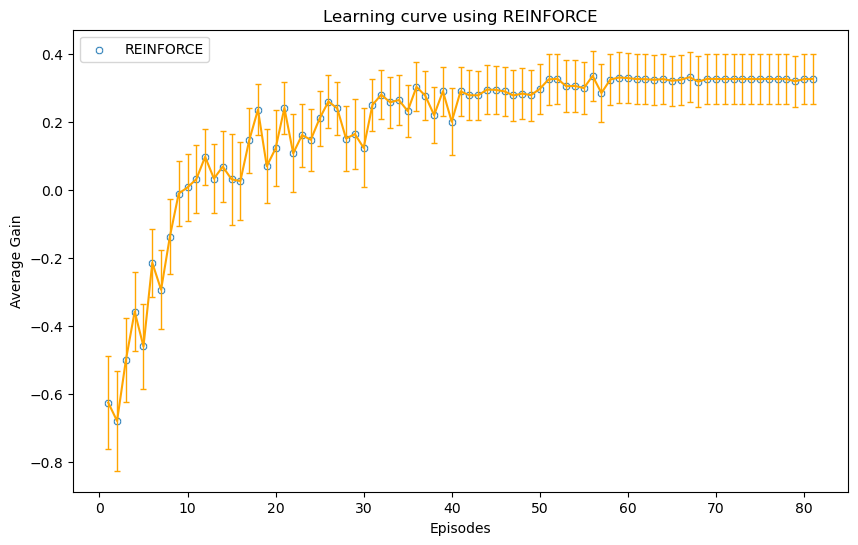

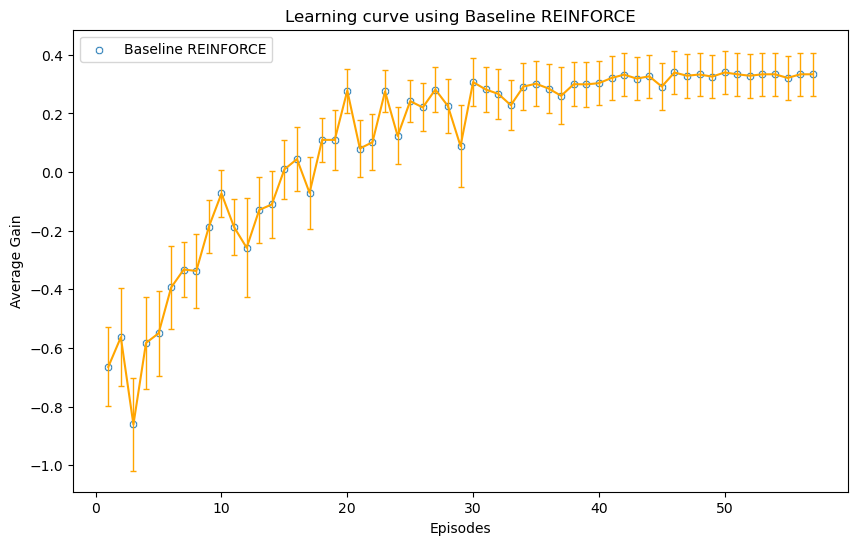

In [15]:
episode_range1 = range(1, len(avg_gain_reinforce) + 1)
episode_range2 = range(1, len(avg_gain_baseline) + 1)
data_reinforce = pd.DataFrame({
    'Episodes': episode_range1,
    'Average Gain': avg_gain_reinforce,
    'Error': error_reinforce,
    'Algorithm': ['REINFORCE'] * len(episode_range1)
})
data_baseline = pd.DataFrame({
    'Episodes': episode_range2,
    'Average Gain': avg_gain_baseline,
    'Error': error_baseline,
    'Algorithm': ['Baseline REINFORCE'] * len(episode_range2)
})


plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Episodes', 
    y='Average Gain', 
    data=data_reinforce, 
    label='REINFORCE', 
    marker='$\circ$'
)
plt.errorbar(data_reinforce['Episodes'], data_reinforce['Average Gain'], yerr=data_reinforce['Error'], fmt='', color='orange', ecolor='orange', elinewidth=1, capsize=2)

plt.xlabel('Episodes')
plt.ylabel('Average Gain')
plt.title('Learning curve using REINFORCE')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Episodes', 
    y='Average Gain', 
    data=data_baseline, 
    label='Baseline REINFORCE', 
    marker='$\circ$'
)
plt.errorbar(data_baseline['Episodes'], data_baseline['Average Gain'], yerr=data_baseline['Error'], fmt='', color='orange', ecolor='orange', elinewidth=1, capsize=2)

plt.xlabel('Episodes')
plt.ylabel('Average Gain')
plt.title('Learning curve using Baseline REINFORCE')
plt.legend()
plt.show()

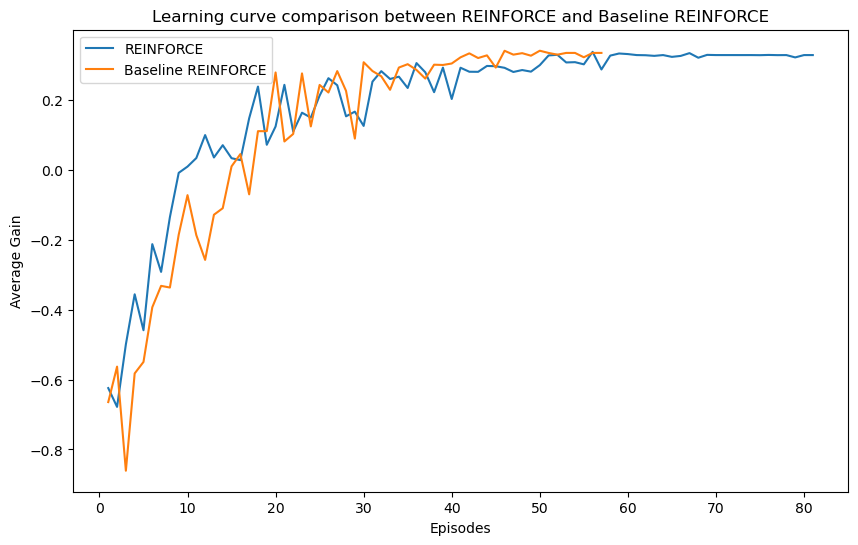

In [7]:
data_combined = pd.concat([data_reinforce, data_baseline])

# Plot 3: Learning curve comparison between REINFORCE and Baseline REINFORCE
plt.figure(figsize=(10, 6))
sns.lineplot(
    x='Episodes', 
    y='Average Gain', 
    hue='Algorithm',
    data=data_combined,
    errorbar=None
)


plt.xlabel('Episodes')
plt.ylabel('Average Gain')
plt.title('Learning curve comparison between REINFORCE and Baseline REINFORCE')
plt.legend()
plt.show()

Both algorithms perform more or less the same on Gridworld.